## Imports and Utility


In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

def euclidean_distance(u, v):
  return np.linalg.norm(u - v)

## SOM Network

In [2]:
class SOM:
  def __init__(self, width, height, ch):
    # Shape of Map
    self.x = width
    self.y = height
    self.ch = ch

    # Nodes (units) in map
    self.units = None

    # Neighborhood units Weights
    self.weights = None

    self.x_delta = None
    self.y_delta = None

    # Neighborhood Radius
    self.radius = None
    self.sigma = None

    # Neighborhood Radius Decay Rate
    self.radius_dr = None

    # Learning Rate
    self.learning_rate_0 = None
    self.learning_rate = None

    # Learning Rate Decay Rate
    self.learning_dr = None

    # a Vector of pixels of shape (m, height, width, ch)
    self.input = None

    self.iterations = None
    self.batch_size = None


  def init_decay_rate(self, learning_dr, radius_dr):
    self.learning_dr = learning_dr
    self.radius_dr = radius_dr


  def update_learning_rate(self, iteration):
    self.learning_rate = self.learning_rate_0 / (1. + self.learning_dr * iteration)


  def update_sigma(self, iteration):
    self.sigma = self.radius / (1. + self.radius_dr * iteration)


  def init_units(self):
    # Init randomly
    input_average = np.mean(self.input) / 0.5
    random_units = np.random.rand(self.y, self.x, self.ch) * input_average

    # Zero padding
    zero_pad_units = np.zeros((
      self.y + 2 * self.radius,
      self.x + 2 * self.radius,
      self.ch
    ))

    zero_pad_units[
      self.radius : self.radius + self.y,
      self.radius : self.radius + self.x
    ] = random_units.copy()

    self.units = zero_pad_units


  def make_neighborhood(self):
    size = self.radius * 2
    self.weights = np.full((size * size, self.ch), 0.0)
    p1 = 1.0 / (2 * math.pi * self.sigma ** 2)
    p_div = 2.0 * self.sigma ** 2

    y_delta = []
    x_delta = []

    for y in range(size):
      for x in range(size):
        ep = -1.0 * ((x - self.radius) ** 2.0 + (y - self.radius) ** 2.0) / p_div
        value = p1 * math.e ** ep
        self.weights[y * size + x] = value
        y_delta.append(y - int(self.radius))
        x_delta.append(x - int(self.radius))

    self.x_delta = np.array(x_delta, dtype=np.int32)
    self.y_delta = np.array(y_delta, dtype=np.int32)

    self.weights -= self.weights[size // 2]

    # Set negative weights to zero
    self.weights[self.weights < 0] = 0

    # Normalize weight vector
    self.weights /= np.max(self.weights)


  # Finding Best Matching Unit (BMU)
  def find_bmu(self, data):
    min_distance = None
    bmu_x = None
    bmu_y = None

    for y in range(self.y):
      for x in range(self.x):
        mu = self.units[
          y + self.radius,
          x + self.radius
        ]
        distance = euclidean_distance(data, mu)
        if min_distance is None or min_distance > distance:
          min_distance = distance
          bmu_x = x
          bmu_y = y

    bmu = {
      'y': bmu_y,
      'x': bmu_x
    }
    return bmu, min_distance


  def update_units(self, bmu_array):
    for i in range(bmu_array.shape[0]):
      unit_y = bmu_array[i, 0]
      unit_x = bmu_array[i, 1]
      data_index = bmu_array[i, 2]
      data = self.input[data_index]

      old = self.units[
        unit_y + self.y_delta + self.radius,
        unit_x + self.x_delta + self.radius
      ]

      diff = (np.expand_dims(data, axis=0) - old)
      updates = self.weights * self.learning_rate * diff

      self.units[
        unit_y + self.y_delta + self.radius,
        unit_x + self.x_delta + self.radius,
        :
      ] += updates


  def remove_zero_pad(self):
    self.units = self.units[
      self.radius : self.radius + self.y,
      self.radius : self.radius + self.x
  ]

  def fit(
    self,
    inputs,
    iterations,
    batch_size,
    learning_rate,
    radius
  ):
    self.input = inputs
    self.iterations = iterations
    self.batch_size = batch_size
    self.learning_rate_0 = learning_rate
    self.learning_rate = learning_rate
    self.radius = int(radius)
    self.sigma = radius

    input_count = self.input.shape[0]
    input_indexes = np.arange(input_count)
    batch_count = math.ceil(input_count / self.batch_size)

    self.init_units()

    for i in range(self.iterations):
      np.random.shuffle(input_indexes)
      total_distance = 0
      total_count = 0
      self.make_neighborhood()

      for b in range(batch_count):
        steps_in_batch = self.batch_size
        steps_left = input_count - b * self.batch_size
        if steps_left < self.batch_size:
          steps_in_batch = steps_left

        bmu_array = np.zeros((steps_in_batch, 3), dtype=np.int32)

        for s in range(steps_in_batch):
          total_count += 1
          data_index = input_indexes[b * self.batch_size + s]
          data = self.input[data_index]
          bmu, min_distance = self.find_bmu(data)
          bmu_array[s, 0] = bmu['y']
          bmu_array[s, 1] = bmu['x']
          bmu_array[s, 2] = data_index
          total_distance += min_distance

        # Update units weights in neighborhood after every batch
        self.update_units(bmu_array)

      # Print reports after every iteration
      print('Iteration:', i, 'Average distance:', total_distance / input_count)

      # Decay learning rate after every iteration
      self.update_learning_rate(i + 1)

      # Decay neighborhood radius (sigma) after every iteration
      self.update_sigma(i + 1)

    # Final units weights after all iterations
    self.remove_zero_pad()


  def get_units(self):
    return self.units

## Dataset and Hyperparameters

In [3]:
dataset = (np.random.standard_normal([1600, 3]) * 255).astype(np.uint8)
untrained_map = dataset.reshape(40, 40, 3).astype(np.uint8)

WIDTH = 40
HEIGHT = 40
DEPTH = 3
ITERATIONS = 20
BATCH_SIZE = 40
LEARNING_RATE = 0.25
RADIUS = min(WIDTH, HEIGHT) / 1.3

som = SOM(WIDTH, HEIGHT, DEPTH)

## Training

### Train 1
Without Learning rate decay
Without Neighbourhood radius decay

In [4]:
LEARNING_RATE_DECAY = 0
RADIUS_DECAY = 0

som.init_decay_rate(LEARNING_RATE_DECAY, RADIUS_DECAY)
som.fit(dataset, ITERATIONS, BATCH_SIZE, LEARNING_RATE, RADIUS)
train1 = som.get_units().copy().astype(np.uint8)

Iteration: 0 Average distance: 72.1639739287166
Iteration: 1 Average distance: 72.37302008455934
Iteration: 2 Average distance: 72.09280814489802
Iteration: 3 Average distance: 73.11658934074043
Iteration: 4 Average distance: 73.90894142508257
Iteration: 5 Average distance: 71.39676159932158
Iteration: 6 Average distance: 72.19543031404736
Iteration: 7 Average distance: 73.12504289968619
Iteration: 8 Average distance: 72.72490823039307
Iteration: 9 Average distance: 73.25221980089907
Iteration: 10 Average distance: 73.11538699171389
Iteration: 11 Average distance: 73.38925283658304
Iteration: 12 Average distance: 72.96262391116952
Iteration: 13 Average distance: 73.87917091423597
Iteration: 14 Average distance: 72.57298884091702
Iteration: 15 Average distance: 70.97410997433498
Iteration: 16 Average distance: 72.71358863805642
Iteration: 17 Average distance: 73.65370270951826
Iteration: 18 Average distance: 75.23644121230073
Iteration: 19 Average distance: 73.20636049582622


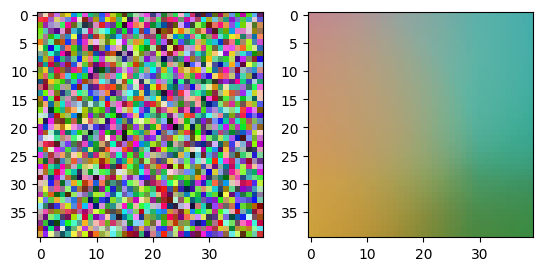

In [5]:
_, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(untrained_map)
ax2.imshow(train1)

### Train 2
With Learning rate decay
Without Neighbourhood radius decay

In [6]:
LEARNING_RATE_DECAY = LEARNING_RATE / ITERATIONS
RADIUS_DECAY = 0

som.init_decay_rate(LEARNING_RATE_DECAY, RADIUS_DECAY)
som.fit(dataset, ITERATIONS, BATCH_SIZE, LEARNING_RATE, RADIUS)
train2 = som.get_units().copy().astype(np.uint8)

Iteration: 0 Average distance: 72.64714365052171
Iteration: 1 Average distance: 72.49358588401695
Iteration: 2 Average distance: 72.39111915454774
Iteration: 3 Average distance: 73.05297076904482
Iteration: 4 Average distance: 74.19011832730662
Iteration: 5 Average distance: 72.29136259103478
Iteration: 6 Average distance: 72.12815255012505
Iteration: 7 Average distance: 72.21273548345572
Iteration: 8 Average distance: 71.84119106143683
Iteration: 9 Average distance: 72.51048088662056
Iteration: 10 Average distance: 73.23141971312867
Iteration: 11 Average distance: 70.1037448569371
Iteration: 12 Average distance: 71.96687177483744
Iteration: 13 Average distance: 74.02099796810218
Iteration: 14 Average distance: 73.88126410407035
Iteration: 15 Average distance: 71.08069783571939
Iteration: 16 Average distance: 72.02324636661722
Iteration: 17 Average distance: 72.25445465008512
Iteration: 18 Average distance: 73.73241212970903
Iteration: 19 Average distance: 73.4541541333654


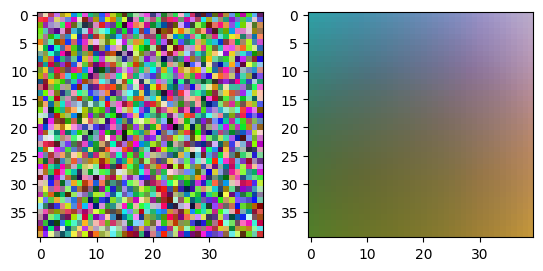

In [7]:
_, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(untrained_map)
ax2.imshow(train2)

### Train 3
With Learning rate decay
With Neighbourhood radius decay

In [8]:
LEARNING_RATE_DECAY = LEARNING_RATE / ITERATIONS
RADIUS_DECAY = RADIUS / ITERATIONS

som.init_decay_rate(LEARNING_RATE_DECAY, RADIUS_DECAY)
som.fit(dataset, ITERATIONS, BATCH_SIZE, LEARNING_RATE, RADIUS)
train3 = som.get_units().copy().astype(np.uint8)

Iteration: 0 Average distance: 71.37648653098387
Iteration: 1 Average distance: 61.891411611915416
Iteration: 2 Average distance: 46.36858129256371
Iteration: 3 Average distance: 37.33178805542299
Iteration: 4 Average distance: 31.280952176899813
Iteration: 5 Average distance: 27.82532160887247
Iteration: 6 Average distance: 24.58019490829052
Iteration: 7 Average distance: 22.34994608679582
Iteration: 8 Average distance: 20.412509871474327
Iteration: 9 Average distance: 19.06334598023256
Iteration: 10 Average distance: 17.806428912309226
Iteration: 11 Average distance: 16.925349325296345
Iteration: 12 Average distance: 16.04912978162243
Iteration: 13 Average distance: 15.415564151893557
Iteration: 14 Average distance: 14.777650470791421
Iteration: 15 Average distance: 14.096011916416874
Iteration: 16 Average distance: 13.577068824940367
Iteration: 17 Average distance: 13.102282588768391
Iteration: 18 Average distance: 12.633216873045681
Iteration: 19 Average distance: 12.21583474758278

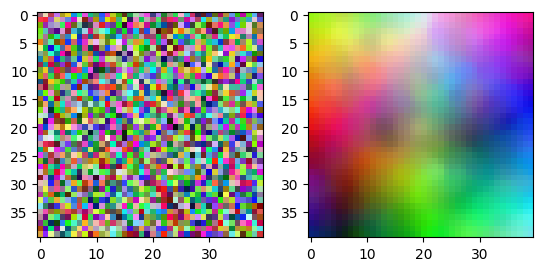

In [9]:
_, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(untrained_map)
ax2.imshow(train3)

## Results

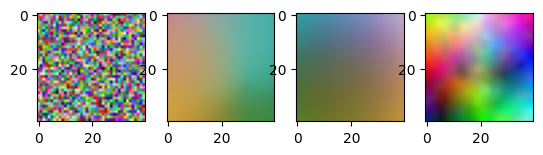

In [10]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)

ax1.imshow(untrained_map)   # Untrained
ax2.imshow(train1)          # w/o Learning rate decay, w/o Neighbourhood radius decay
ax3.imshow(train2)          # with Learning rate decay, w/o Neighbourhood radius decay
ax4.imshow(train3)          # with Learning rate decay, with Neighbourhood radius decay